# Regression Proyect

The objective of this project is to practice regression techniques that you have learned in this class.  
To goal is to develop a machine learning model that can accurately predict the price of Airbnb properties in the San Francisco Bay Area.
Using the a few of the following models:
- Linear regression (including polynomial and regularized regression)  
- K-nearest neightbors  
- Decision trees  
- Support vector machines 

### Load Packages

In [1]:
import ast
import re
# from collections import Counter, defaultdict
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer

### Load the Data

In [2]:
# Read the file
df = pd.read_csv('train.csv')

### EDA

In [ ]:
# Overview of Data
df.info()

We have too many columns. Select columns based on what you think will have an impact in predicting price. Remove the other columns from df.  
We also know we have missing information. We will take care of those later.

In [3]:
# Remove unnecessary columns
df.columns
remove_cols = ['Id', 'name', 'neighborhood_overview', 'host_about']
new_df = df.drop(columns=remove_cols)

need_clean = ['host_since', 'host_location', 'host_response_rate', 'host_acceptance_rate', 'host_verifications',
              'bathrooms_text', 'amenities', 'first_review', 'last_review']

In [ ]:
def compute_weights(epsilon, d, p=2):
    return np.power(epsilon-d, p)/np.power(epsilon, p)

R = 6371

def haversine(x0, y0, x_vector, y_vector):
    x = np.deg2rad(x0)
    y = np.deg2rad(y0)
    lat = np.deg2rad(x_vector)
    long = np.deg2rad(y_vector)
    xdiff = x-lat
    ydiff = y-long
    
    d = np.sin(xdiff / 2)**2 + np.cos(x) * np.cos(lat) * np.sin(ydiff / 2)**2
    c = 2 * np.arctan2(np.sqrt(d), np.sqrt(1-d))
    km = R*c

    return km

In [5]:
# Clean my data

def data_pipeline(input_df, base=df):
    # Extract most importnant amenities from amenitites column
    # Create columns for the most important amenities
    important_amenities = ['oven', 'hair dryer', 'dishes and silverware', 'bathtub', 'stove', 'hot tub', 'dedicated workspace', 'hdtv', 'luggage dropoff', 'smoke detector', 'carbon monoxide',
     'fire extinguisher', 'cleaning products', 'balcony', 'patio', 'roomdarkening shades', 'shampoo', 'shower gel', 'private entrance', 'wifi', 'lock on bedroom door', 'refrigerator', 'washer',
     'security cameras', 'conditioner', 'wine glasses', 'hot water', 'pool', 'dryer', 'dishwasher', 'elevator', 'coffee maker', 'free street parking', 'smoke alarm', 'toaster', 'bed linens', 'cooking basics',
     'hot water kettle', 'self checkin', 'keypad', 'kitchen', 'tv', 'gym', 'dining table', 'laptopfriendly workspace', 'iron', 'carbon monoxide alarm', 'essentials', 'heating', 'first aid kit',
     'free breakfast', 'host greets you', 'long term stays allowed', 'freezer', 'coffee', 'laundromat nearby', 'outdoor', 'free parking', 'body soap', 'air conditioning', 'hangers', 'extra pillows and blankets',
     'smoking allowed', 'familyfriendly amenities', 'microwave', 'flexible cancellation', 'pet friendly']

    for amenity in important_amenities:
        input_df[amenity] = False

    input_df['amenities'] = input_df['amenities'].str.replace(r'\" ', 'in ').replace('-', '')
    input_df['amenities'] = input_df['amenities'].str.replace('-', '')
    
    # neighborhood_prices = []
    # epsilon = 1
    
    for i, row in input_df.iterrows():
        
        # Amenities dummy Variables
        amenities_list = row['amenities']
        for amenity in important_amenities:
            input_df.at[i, amenity] = amenity in amenities_list.lower()

    #     #Spatial dependency
    #     x0 = row["latitude"]
    #     y0 = row["longitude"]
        
    #     d = haversine(x0, y0, base["latitude"].values, base["longitude"].values)

    #     indices = np.where(d <= epsilon)[0]
    #     neighborhood = indices[indices != i]

    #     i_type = input_df.iloc[i]["property_type"]
    #     same_types = np.where(base["property_type"].values == i_type)[0]

    #     neighborhood = np.intersect1d(same_types, neighborhood)

    #     weights = compute_weights(epsilon, d[neighborhood])
    #     if len(weights) != 0:
    #         neighborhood_price = sum(base.iloc[neighborhood]["price"]*weights)/sum(weights)
    #     else:
    #         neighborhood_price = None

    #     neighborhood_prices.append(neighborhood_price)

    # input_df["neighborhood_price"] = neighborhood_prices

    return (input_df
        # Create year columns and remove date columns
        .assign(host_since=pd.to_datetime(input_df['host_since']).dt.year,
                first_review=pd.to_datetime(input_df['first_review']).dt.year,
                last_review=pd.to_datetime(input_df['last_review']).dt.year)

        # Extract city and State and remove host_location variable
        .assign(city=input_df['host_location'].str.split(', ', expand=True)[0],
                state=input_df['host_location'].str.split(', ', expand=True)[1])
        .drop(columns=['host_location'])

        # Convert text percentages into decimals
        .assign(host_response_rate=pd.to_numeric(input_df['host_response_rate'].str.strip('%')) / 100,
                host_acceptance_rate=pd.to_numeric(input_df['host_acceptance_rate'].str.strip('%')) / 100)

        # Convert list of verifications to number of verifications
        .assign(host_verifications=input_df['host_verifications'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else []).apply(len))

        # Extract bathroom and bathroom type from bathroom column
        .assign(bathrooms=input_df['bathrooms_text'].str.extract('(\d*\.?\d+)').astype(float).fillna(0),
                bathroom_type=input_df['bathrooms_text'].apply(lambda x: re.sub(r'[\d.]+', '', str(x)).strip())
                                                    .apply(lambda x: 'shared' if 'shared' in x
                                                                   else 'private' if 'private' in x
                                                                   else 'half-bath' if '-' in x
                                                                   else 'regular'))
        .drop(columns=['bathrooms_text'])

        # Convert amenities into a new column that has the number of amenitites in the place
        .assign(amenities=input_df['amenities'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else []).apply(len))
    )
new_df = data_pipeline(df)

In [ ]:
# # Get a set of all unique amenities in the dataset that are the most common
# new_df['amenities'] = new_df['amenities'].str.replace(r'\" ', 'in ').replace('-', '')
# new_df['amenities'] = new_df['amenities'].str.replace('-', '')
# new_df['amenities'] = new_df['amenities'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
# unique_amenities = set(amenity for amenities_list in new_df['amenities'] for amenity in amenities_list)
# unique_amenities
# amenity_counts = defaultdict(int)
# for amenities_list in new_df['amenities']:
#     for amenity in amenities_list:
#         amenity_counts[amenity.lower()] += 1
# amenity_counts = Counter(amenity for amenities_list in new_df['amenities'] for amenity in amenities_list)
# amts_df = pd.DataFrame(list(amenity_counts.items()), columns=['Amenity', 'Count'])
# amts_df = amts_df.sort_values(by='Count', ascending=False).head(50)
# new_amts = list(amts_df['Amenity'])
# new_amts = [amenity.lower() for amenity in new_amts]
# new_amts

Check for Multicolinearity

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_df = new_df.select_dtypes(include=['float64', 'int64']) # select numeric columns
predictors = numeric_df.drop(['price'], axis=1) # remove target variable
predictors = predictors.fillna(predictors.mean()) # Fill in NA with mean values
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])] # Get inflation Factors
vars_multicolinearity = list(vif_data[vif_data['VIF'] > 10]['Variable']) # identify columns that might be correlated
vif_data[vif_data['VIF'] > 10]

,Variable,VIF
14,maximum_minimum_nights,305.727340
15,minimum_maximum_nights,155.234077
16,maximum_maximum_nights,34.091343
17,minimum_nights_avg_ntm,333.631858
18,maximum_nights_avg_ntm,258.021075
19,availability_30,10.997443
20,availability_60,52.374709
21,availability_90,29.912282


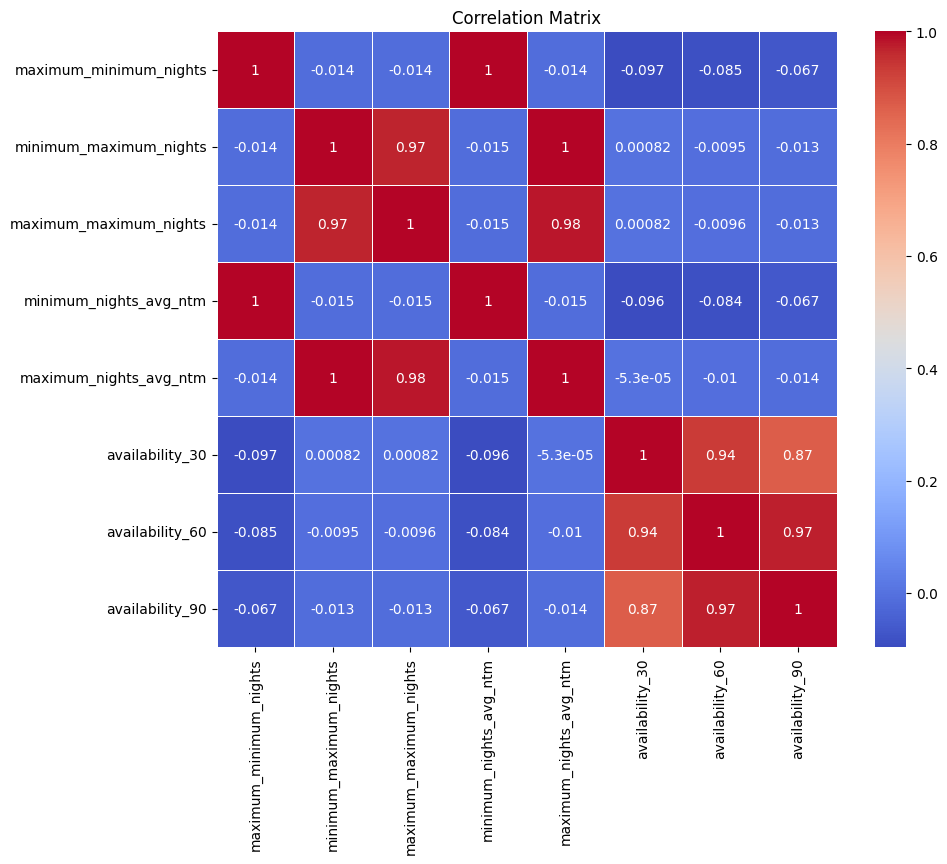

In [7]:
# Check for multicolinearity

# Select variables that might have multicorrelation
multi_df = new_df[vars_multicolinearity]

# Calculate the correlation matrix
correlation_matrix = multi_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Based on the Correlation matrix graph, we are going to remove the following columns:
- availability_30
- availability_90
- maximum_maximum_nights
- minimum_nights_avg_ntm
- maximum_nights_avg_ntm

In [8]:
new_df = new_df.drop(['availability_30', 'availability_90','maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1)

### Prepare the data

In [36]:
# Get your X with numeric features
X = new_df.drop(columns=['price'])
# Get you y
y = new_df['price']
# Partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307, train_size=0.75)

# Numeric features and categorical features
numeric_features = ['host_listings_count',
       'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
       'number_of_reviews', 'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'bathrooms']
categorical_features = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'has_availability', 'instant_bookable', 'city', 'state',
       'bathroom_type', 'oven', 'hair dryer', 'dishes and silverware', 'bathtub', 'stove', 'hot tub', 'dedicated workspace', 
       'hdtv', 'luggage dropoff', 'smoke detector', 'carbon monoxide',
       'fire extinguisher', 'cleaning products', 'balcony', 'patio', 'roomdarkening shades', 'shampoo', 'shower gel', 
       'private entrance', 'wifi', 'lock on bedroom door', 'refrigerator', 'washer',
       'security cameras', 'conditioner', 'wine glasses', 'hot water', 'pool', 'dryer', 'dishwasher', 'elevator', 
       'coffee maker', 'free street parking', 'smoke alarm', 'toaster', 'bed linens', 'cooking basics',
       'hot water kettle', 'self checkin', 'keypad', 'kitchen', 'tv', 'gym', 'dining table', 'laptopfriendly workspace', 
       'iron', 'carbon monoxide alarm', 'essentials', 'heating', 'first aid kit',
       'free breakfast', 'host greets you', 'long term stays allowed', 'freezer', 'coffee', 'laundromat nearby',
       'outdoor', 'free parking', 'body soap', 'air conditioning', 'hangers', 'extra pillows and blankets',
       'smoking allowed', 'familyfriendly amenities', 'microwave', 'flexible cancellation', 'pet friendly']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Handle missing data
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle missing data
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ('select_percentile', SelectPercentile(score_func=f_regression, percentile=50))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Check for potential outliers

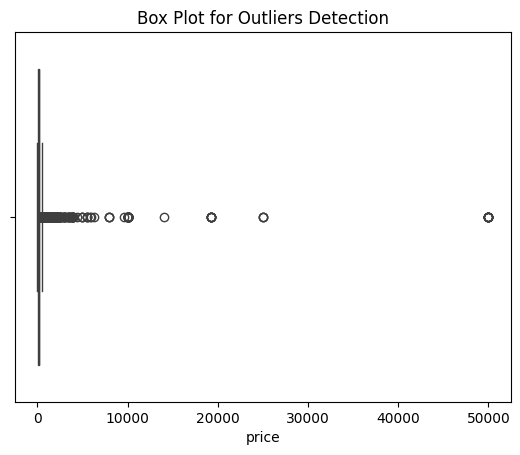

In [10]:
sns.boxplot(x=new_df['price'])
plt.title('Box Plot for Outliers Detection')
plt.show()

In [11]:
new_df[new_df['price']>1500].shape

(171, 116)

In [12]:
171/new_df.shape[0]

0.011195495613460784

In [13]:
from scipy.stats import zscore

z_scores = zscore(new_df['price'])
outliers = (z_scores > 3) | (z_scores < -3)

Handle Outliers (Cap to 3 standard deviation)

In [14]:
# Assuming 'numeric_column' is the column with outliers
mean_value = new_df['price'].mean()
std_dev = new_df['price'].std()

# Define the standard cap as 3 standard deviations from the mean
cap_threshold = mean_value + 3 * std_dev

# Cap values beyond the threshold
new_df['price'] = np.clip(new_df['price'], a_min=None, a_max=cap_threshold)

Check for duplicates

In [15]:
df.duplicated().sum()

0

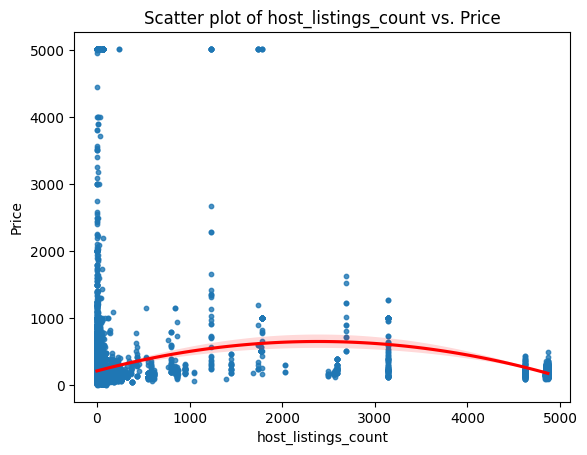

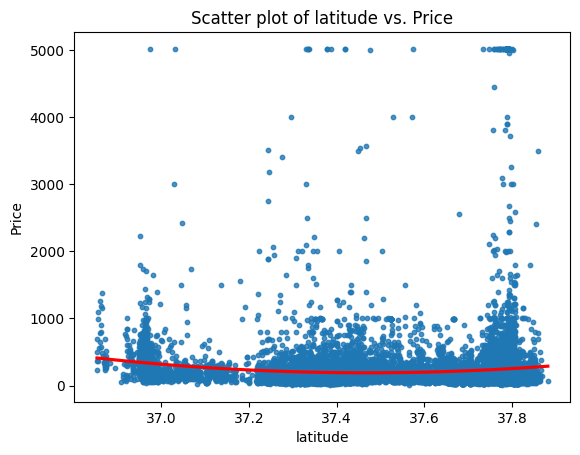

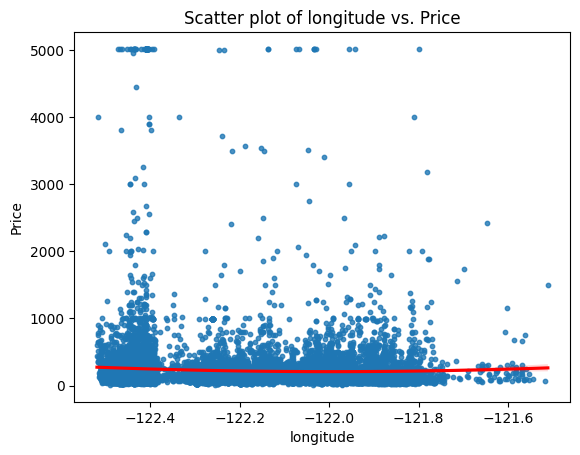

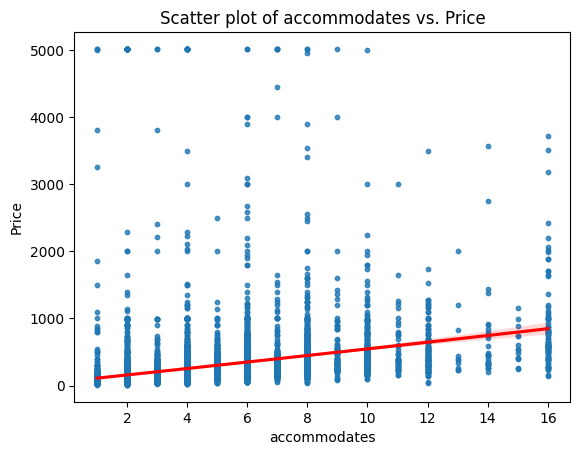

/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


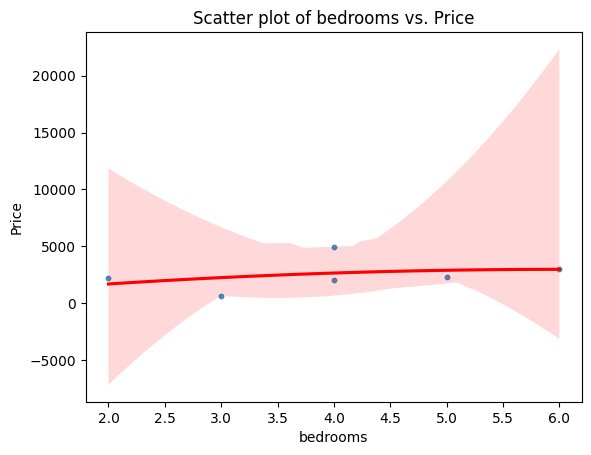

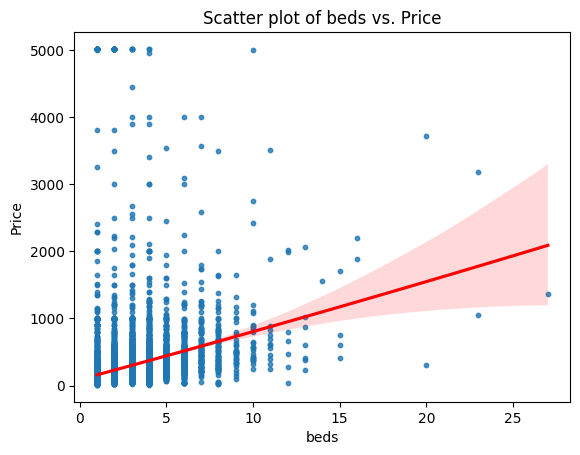

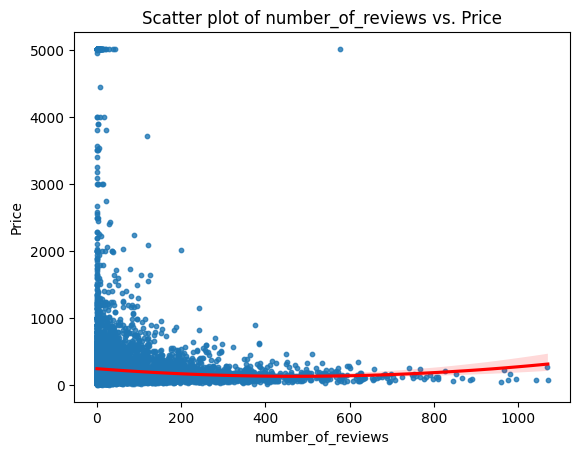

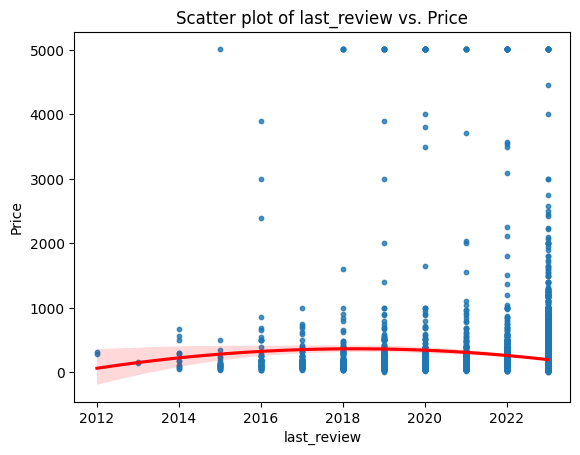

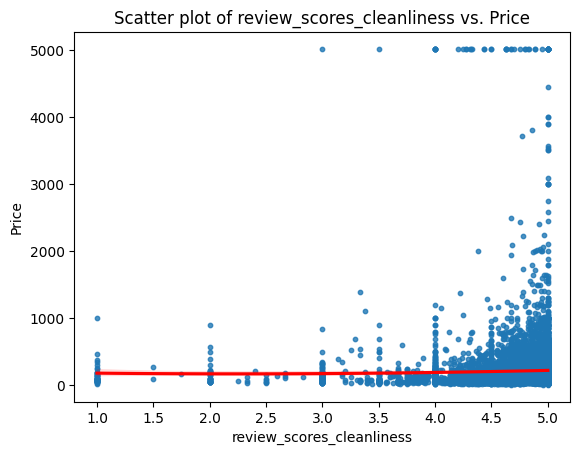

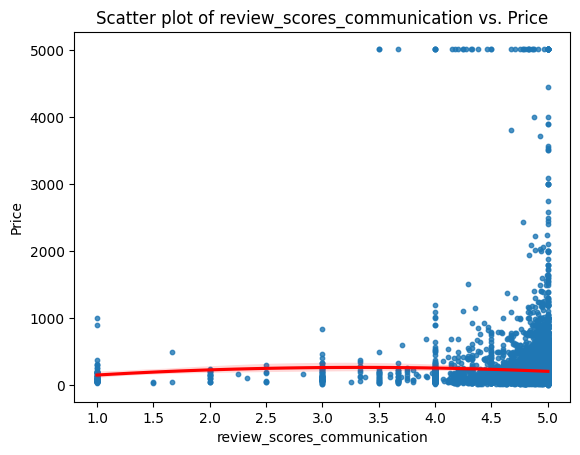

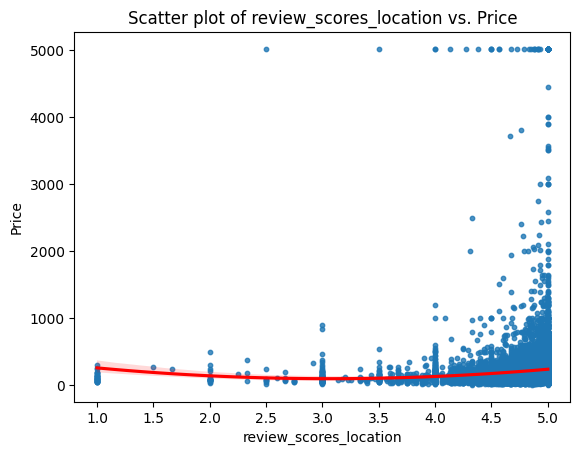

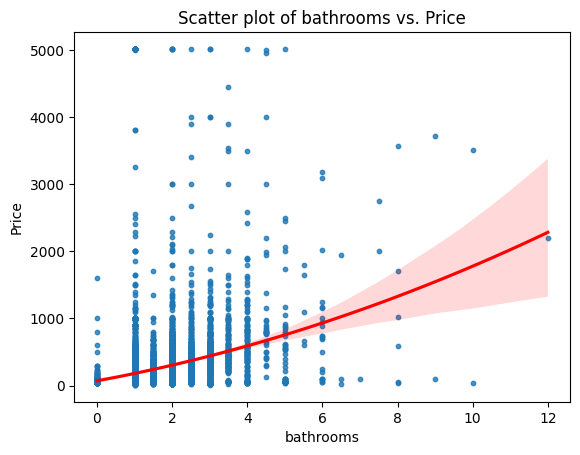

In [24]:
for feature in numeric_features:
    sns.regplot(x=feature, y='price', data=new_df, scatter_kws={'s': 10}, line_kws={'color': 'red'}, order=2)
    plt.title(f'Scatter plot of {feature} vs. Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

### KNN

Do 10 fold cross validation to check for the following parameters:
- Polinomial Features
- Number of Neighbors
- Weights method

In [16]:
scoring_metric = 'neg_mean_absolute_error'

In [35]:
# Add the KNeighborsRegressor model to the pipeline
knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(weights='distance', n_neighbors=2)) # Proximity may make a big difference in some of our features thereofre use 'distance'
])

# Define the parameter grid
params = {
    'model__n_neighbors': (3,5)
}

# Instantiate GridSearchCV
gs1 = GridSearchCV(knn_pipe, param_grid=params, scoring=scoring_metric, cv=4, verbose=2)
gs1.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ...............................model__n_neighbors=3; total time=   0.2s
[CV] END ...............................model__n_neighbors=3; total time=   0.0s
[CV] END ...............................model__n_neighbors=3; total time=   0.0s
[CV] END ...............................model__n_neighbors=3; total time=   0.0s
[CV] END ...............................model__n_neighbors=5; total time=   0.0s
[CV] END ...............................model__n_neighbors=5; total time=   0.0s
[CV] END ...............................model__n_neighbors=5; total time=   0.1s
[CV] END ...............................model__n_neighbors=5; total time=   0.1s


ValueError: 
All the 8 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 727, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 658, in _fit_transform
    return Parallel(n_jobs=self.n_jobs)(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/joblib/parallel.py", line 1863, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/joblib/parallel.py", line 1792, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 436, in fit_transform
    fit_params_steps = self._check_fit_params(**fit_params)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 320, in _check_fit_params
    fit_params_steps = {name: {} for name, step in self.steps if step is not None}
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/isaacaguilar/anaconda3/envs/new_deep/lib/python3.11/site-packages/sklearn/pipeline.py", line 320, in <dictcomp>
    fit_params_steps = {name: {} for name, step in self.steps if step is not None}
                                     ^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


In [27]:
# Show parameters that gave the best model
best_params = gs1.best_params_
best_mae = -gs1.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_mae}")

# Get the best pipeline from the GridSearchCV results
best_pipeline = gs1.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {mae_test}")

Best Hyperparameter Combinations: {'model__n_neighbors': 5}
Train MAE: 98.85862433142158
MAE test: 110.71797689133719


Use the optimized pipeline to get predictions for the test data

### Linear Regression (No Penalty)

Do 10 Fold cross validation to check for the following parameters:
- Polinomial Features

In [ ]:
# Add the LinnearRegressor model to the pipeline
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lm_pipe.fit(X_train, y_train)

In [ ]:
y_train_pred = lm_pipe.predict(X_train)
y_test_pred = lm_pipe.predict(X_test)
# Calculate the MAE
MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {MAE_train}")
print(f"MAE test: {MAE_test}")

### Ridge Regression

In [ ]:
# Create RidgeCV model with 10-fold cross-validation
rg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

params = {
    'model__alpha': np.logspace(-6, 6, 10) # Best alpha 1e-06
}

ridge_cv = GridSearchCV(rg_pipe, param_grid=params, scoring=scoring_metric, cv=5, verbose=2)
ridge_cv.fit(X_train, y_train)

# Fit the model on training data
ridge_cv.fit(X_train, y_train)

In [ ]:
best_params = ridge_cv.best_params_
best_MAE3 = -ridge_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE3}")

# Get the best pipeline from the GridSearchCV results
best_pipeline3 = ridge_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline3.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

### Lasso Rigression

In [ ]:
lso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

params = {
    'model__alpha': np.logspace(-6, 6, 10) # Best Alpha 0.21544346900318823
}

lasso_cv = GridSearchCV(lso_pipe, param_grid=params, scoring=scoring_metric, cv=5, verbose=2)

# Fit the model on training data
lasso_cv.fit(X_train, y_train)

In [ ]:
best_params = lasso_cv.best_params_
best_MAE4 = -lasso_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE4}")

# Get the best pipeline from the GridSearchCV results
best_pipeline4 = lasso_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline4.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
# Define the Random Forest model
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=70, min_samples_leaf=2))
])

# Define the hyperparameters for Random Forest
params = {
    'model__min_samples_leaf': [2,3]
}

# Create the Random Forest GridSearchCV
rf_cv = GridSearchCV(rf_pipe, param_grid=params, scoring=scoring_metric, cv=4, verbose=2)

# Fit the Random Forest model on training data
rf_cv.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ..........................model__min_samples_leaf=2; total time=  38.2s
[CV] END ..........................model__min_samples_leaf=2; total time=  27.5s
[CV] END ..........................model__min_samples_leaf=2; total time=  42.1s
[CV] END ..........................model__min_samples_leaf=2; total time=  31.2s
[CV] END ..........................model__min_samples_leaf=3; total time=  27.0s
[CV] END ..........................model__min_samples_leaf=3; total time=  36.4s
[CV] END ..........................model__min_samples_leaf=3; total time=  34.2s
[CV] END ..........................model__min_samples_leaf=3; total time=  45.8s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_listings_count',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'number_of_reviews',
                                                                          'review_scores_cleanliness',
                                                                          'review_scores_communication',
                                                                          'review_scores_locat...
                                                                          'workspace',
                                                                          'hdtv',
                                                                          'luggage '
                                                                          'dropoff',
                                                                          'smoke '
                                                                          'detector',
                                                                          'carbon '
                                                                          'monoxide',
                                                                          'fire '
                                                                          'extinguisher',
                                                                          'cleaning '
                                                                          'products',
                                                                          'balcony',
                                                                          'patio',
                                                                          'roomdarkening '
                                                                          'shades',
                                                                          'shampoo',
                                                                          'shower '
                                                                          'gel', ...])])),
                                       ('model',
                                        RandomForestRegressor(min_samples_leaf=2,
                                                              n_estimators=70))]),
             param_grid={'model__min_samples_leaf': [2, 3]},
             scoring='neg_mean_absolute_error', verbose=2)

In [42]:
best_params = rf_cv.best_params_
best_MAE5 = -rf_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE5}")

# Get the best pipeline from the GridSearchCV results
best_pipeline5 = rf_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline5.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

Best Hyperparameter Combinations: {'model__min_samples_leaf': 3}
Train MAE: 94.99128516663559
MAE test: 110.7829127743062


### Support Vector Machine 

In [43]:
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [51]:
# Define the SVM model
svm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('pca', PCA(kernel='linear')),  # Add PCA as a preprocessing step
    ('model', SVR())
])

# Define the hyperparameters for SVM
params = {
    'model__C': [10, 15],  # Adjust the values based on your preference
    'model__kernel': ['linear', 'rbf'],  # Adjust the kernel based on your preference
}

# Create the SVM GridSearchCV
svm_cv = GridSearchCV(svm_pipe, param_grid=params, scoring=scoring_metric, cv=4, verbose=2)

# Fit the SVM model on training data
svm_cv.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[CV] END ..................model__C=10, model__kernel=linear; total time=  59.6s
[CV] END ..................model__C=10, model__kernel=linear; total time=  59.2s
[CV] END ..................model__C=10, model__kernel=linear; total time= 1.0min
[CV] END ..................model__C=10, model__kernel=linear; total time= 1.1min
[CV] END .....................model__C=10, model__kernel=rbf; total time= 1.1min
[CV] END .....................model__C=10, model__kernel=rbf; total time= 1.3min
[CV] END .....................model__C=10, model__kernel=rbf; total time= 1.2min
[CV] END .....................model__C=10, model__kernel=rbf; total time= 1.2min
[CV] END ..................model__C=15, model__kernel=linear; total time= 1.1min
[CV] END ..................model__C=15, model__kernel=linear; total time= 1.1min
[CV] END ..................model__C=15, model__kernel=linear; total time= 1.1min
[CV] END ..................model__C=15, model__kernel=linear; total time= 1.0min
[CV] END ...................

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_listings_count',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'number_of_reviews',
                                                                          'review_scores_cleanliness',
                                                                          'review_scores_communication',
                                                                          'review_scores_locat...
                                                                          'bathtub',
                                                                          'stove',
                                                                          'hot '
                                                                          'tub',
                                                                          'dedicated '
                                                                          'workspace',
                                                                          'hdtv',
                                                                          'luggage '
                                                                          'dropoff',
                                                                          'smoke '
                                                                          'detector',
                                                                          'carbon '
                                                                          'monoxide',
                                                                          'fire '
                                                                          'extinguisher',
                                                                          'cleaning '
                                                                          'products',
                                                                          'balcony',
                                                                          'patio',
                                                                          'roomdarkening '
                                                                          'shades',
                                                                          'shampoo',
                                                                          'shower '
                                                                          'gel', ...])])),
                                       ('model', SVR())]),
             param_grid={'model__C': [10, 15],
                         'model__kernel': ['linear', 'rbf']},
             scoring='neg_mean_absolute_error', verbose=2)

In [52]:
best_params = svm_cv.best_params_
best_MAE6 = -svm_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE6}")

# Get the best pipeline from the GridSearchCV results
best_pipeline6 = svm_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline6.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

Best Hyperparameter Combinations: {'model__C': 15, 'model__kernel': 'rbf'}
Train MAE: 99.3195731906169
MAE test: 111.65380314337875


### XGBOOST

In [45]:
from xgboost import XGBRegressor

In [47]:
# Define the XGBoost model in a pipeline
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Your preprocessor, assuming it's defined earlier
    ('model', XGBRegressor(n_estimators=100))  # XGBoost model
])

# Define the hyperparameters for XGBoost
params = {
    'model__learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate based on your preference
    'model__max_depth': [3, 5, 7],  # Adjust the maximum depth based on your preference
}

# Create the XGBoost GridSearchCV
xgb_cv = GridSearchCV(xgb_pipe, param_grid=params, scoring=scoring_metric, cv=4, verbose=2)

# Fit the XGBoost model on training data
xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END ......model__learning_rate=0.01, model__max_depth=3; total time=   8.3s
[CV] END ......model__learning_rate=0.01, model__max_depth=3; total time=   7.3s
[CV] END ......model__learning_rate=0.01, model__max_depth=3; total time=   7.3s
[CV] END ......model__learning_rate=0.01, model__max_depth=3; total time=   7.5s
[CV] END ......model__learning_rate=0.01, model__max_depth=3; total time=   7.2s
[CV] END ......model__learning_rate=0.01, model__max_depth=5; total time=  12.3s
[CV] END ......model__learning_rate=0.01, model__max_depth=5; total time=  14.3s
[CV] END ......model__learning_rate=0.01, model__max_depth=5; total time=  10.8s
[CV] END ......model__learning_rate=0.01, model__max_depth=5; total time=  10.8s
[CV] END ......model__learning_rate=0.01, model__max_depth=5; total time=  13.2s
[CV] END ......model__learning_rate=0.01, model__max_depth=7; total time=  26.9s
[CV] END ......model__learning_rate=0.01, model__max_depth=7; total time=  21.1s
[CV] END ......model__learni

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_listings_count',
                                                                          'latitude',
                                                                          'longitude',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'number_of_reviews',
                                                                          'review_scores_cleanliness',
                                                                          'review_scores_communication',
                                                                          'review_scores_locat...
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7]},
             scoring='neg_mean_absolute_error', verbose=2)

In [48]:
best_params = xgb_cv.best_params_
best_MAE7 = -xgb_cv.best_score_  # Note the negative sign due to neg_mean_absolute_error
print(f"Best Hyperparameter Combinations: {best_params}")
print(f"Train MAE: {best_MAE7}")

# Get the best pipeline from the GridSearchCV results
best_pipeline7 = xgb_cv.best_estimator_

# Make predictions on the test data
y_pred = best_pipeline7.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred)
print(f"MAE test: {MAE_test}")

Best Hyperparameter Combinations: {'model__learning_rate': 0.1, 'model__max_depth': 7}
Train MAE: 93.42733913200567
MAE test: 106.66818149174725


### Stack model

In [53]:
from sklearn.model_selection import cross_val_predict, KFold

# Ensure consistent random state for reproducibility
random_state = 42

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=70, min_samples_leaf=3))
])

knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(weights='distance', n_neighbors=3)) 
])
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Your preprocessor, assuming it's defined earlier
    ('model', XGBRegressor(n_estimators=100, learning_rate=.1, max_depth=7))  # XGBoost model
])

svm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('pca', PCA(kernel='linear')),  # Add PCA as a preprocessing step
    ('model', SVR())
])

base_learners = [
    ('svm', svm_pipe),
    ('xgb', xgb_pipe)
]

meta_learner = RandomForestRegressor(random_state=random_state)

cv = KFold(n_splits=4, shuffle=True, random_state=random_state)

meta_X = np.zeros((X_train.shape[0], len(base_learners))) # For collecting output from base learners

for i, (clf_name, clf) in enumerate(base_learners):
    clf.fit(X_train, y_train)
    predictions = cross_val_predict(clf, X_train, y_train, cv=cv)
    meta_X[:, i] = predictions
    print(f"Done training {clf_name}")

# Fit meta learner
meta_learner.fit(meta_X, y_train)
print("Done fitting meta learner")

# Predictions from base learners on the test set
base_predictions = [cross_val_predict(clf, X_test, y_test, cv=cv)
                   for _, clf in base_learners]
meta_X_test = np.column_stack(base_predictions)

# Predictions from meta learner
meta_predictions = meta_learner.predict(meta_X_test)

print("Accuracy of Meta-learner:", mean_absolute_error(y_test, meta_predictions))

Done training svm
Done training xgb
Done fitting meta learner
Accuracy of Meta-learner: 140.25131838195503


KNN: 110.71 3 nn  
Linear Regression: 14300994833.4  
Ridge: 242.12  
Lasso: 245.94  
SVM: 111.65  
Random Forest: 110.78  
XGBoost: 106.66 (Best Model)  
Stack (KNN & RF): 127.62  
Stack (KNN & XGB): 131.36  
Stack (SVM & XGB): 140.25  

### Use Best Model on Test/Validation Set

In [ ]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(C=10, kernel='linear'))
])

final_model.fit(X_train, y_train)

In [28]:
# Validation Data
val = pd.read_csv("test.csv")
new_val = data_pipeline(val)
preds = best_pipeline.predict(new_val) # Use best model

In [29]:
preds_df = pd.DataFrame({
    "Id": val['Id'],
    "price": preds
})

In [30]:
# Write your preds for you validaiton data set
preds_df.to_csv("preds.csv", index=False)

### Identify Features that Impact Price the most

In [ ]:
# What features are more important
feature_names = preprocessor.get_feature_names_out()
coefficients = best_pipeline4.named_steps['model'].coef_

# Zip feature names with their coefficients
feature_importance = pd.DataFrame(list(zip(feature_names, np.abs(coefficients))), columns=['Feature', 'Coefficient'])
feature_importance.sort_values(by='Coefficient', ascending=False)